In [53]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt

# Medical Image Computing - Exercise 2

Jasmin Eder, Dorothea Mauracher, Sonja Pappenberger

## Image texture descriptors
#### 1.1 Load the image “breastXray.tif”. Split the image into non-overlapping blocks of 20 x 20 pixels. What is the original image size and hence how many blocks/regions are processed in the following steps?

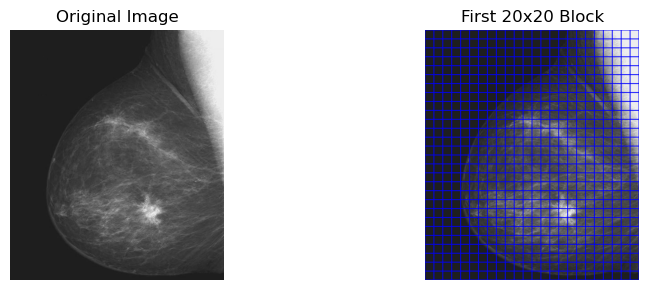

Image width: 480 pixels
Image height: 560 pixels
Number of channels: 3
Total number of blocks in the image: 672


In [54]:
# Read the image
image_bgr = cv2.imread("breastXray.tif", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
# Convert it to a bgr image
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Get size of the image
height, width, channels = image_rgb.shape

# Define block size
block_size = 20

# Calculate the number of blocks in both dimensions
blocks_height = height // block_size
blocks_width = width // block_size

# Calculate the total number of blocks
total_blocks = blocks_height * blocks_width

# Split the image into blocks
blocks = []
for i in range(blocks_height):
    for j in range(blocks_width):
        block = image_rgb[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
        blocks.append(block)
             
# Create a copy of the image to draw rectangles on
image_with_blocks = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

# Draw rectangles around each block on the image
for i in range(num_blocks_height):
    for j in range(num_blocks_width):
        cv2.rectangle(image_with_blocks, (j * block_size, i * block_size),
                      ((j + 1) * block_size - 1, (i + 1) * block_size - 1), (0, 0, 255), 1)

# Plot the original image
fig, axs = plt.subplots(1, 2, figsize=(10,3))
axs[0].imshow(image_rgb)
axs[0].axis('off')
axs[0].set_title('Original Image')
# Plot the split image
axs[1].imshow(image_with_blocks, cmap='gray')
axs[1].axis('off')
axs[1].set_title('First 20x20 Block')
plt.tight_layout()
plt.show()

print(f"Image width: {width} pixels")
print(f"Image height: {height} pixels")
print(f"Number of channels: {channels}")
print(f'Total number of blocks in the image: {total_blocks}')

The original image size is 560 pixel x 480 pixels and the split image has a total of 672 blocks.
    

#### 1.2 Determine the gray level co-occurrence matrix (GLCM) for each region/block using a position operator [Dx, Dy]. Choose a distance, e.g. D = 1, and extract the GLCM at four different directions [0°, 45°, 90°, 135°]. The number of gray levels should be set to 16. What is the size of one GLCM?

In [ ]:
# Definitions for GLCM calculation
distance = [1] 
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles in radians: 0°, 45°, 90°, 135°

# Number of gray levels
gray_levels = 256         # mit 256 gehts, mit 16 nicht?

# Calculate GLCM for each block at different angles
glcms = []
glcm_size = None
     
for block in blocks:
    # Convert block to 2D (in case it has more dimensions)
    if len(block.shape) > 2:
        block = np.mean(block, axis=2).astype(np.uint8)  # Convert to grayscale if it's a color image

    glcm = graycomatrix(block, distances=distance, angles=angles, levels=gray_levels, symmetric=True, normed=True)
    glcms.append(glcm)
    if glcm_size is None:
        glcm_size = glcm.shape
   

print(f"Size of one GLCM: {glcm_size}")


mit gray level 256 gehts, mit 16 nicht?       The size of one GLCM is ..... 

#### 1.3 Calculate the correlation, contrast, energy and homogeneity for each GLCM. Show processed images based on the descriptors, i.e. Correlation at four directions with D = 1, Contrast at four directions with D =1, etc., using subplots (see Figure 1). How many features did you extract? Comment on the differences between the different texture descriptors

In [ ]:
#Geht noch nicht

distance = 1
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Calculate features of GLCM
 
for glcm in glcms:
    correlation = [graycoprops(glcm, 'correlation')]
    contrast = [graycoprops(glcm, 'contrast')]
    energy = [graycoprops(glcm, 'energy')]
    homogeneity = [graycoprops(glcm, 'homogeneity')]

# Display processed images based on the descriptors
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

descriptors = [correlation, contrast, energy, homogeneity]
descriptor_names = ['Correlation', 'Contrast', 'Energy', 'Homogeneity']

for i, (descriptor, name) in enumerate(zip(descriptors, descriptor_names)):
    ax = axes[i]
    ax.set_title(name)
    ax.imshow(descriptor, cmap='viridis')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Calculate the total number of features extracted
total_features = len(angles) * len(descriptor_names)
print(f"Total number of features extracted: {total_features}")
    
    

#### 1.4 Build a design/data matrix based on your blocks where each block/region is an observation (sample) and the texture descriptors are the features. Normalize the features in the design matrix between 0 and 1. What is the size of your design matrix?

#### 1.5. (BONUS, 1 extra point) Try two different pixel distances D, e.g. 1 and 3, and show the processed images using subplots. Comment on the influence of the distance parameter. Decide for one of the two distances D to be used in the design matrix for the second part of the exercise.

## Texture-based clustering
#### 2.1. Cluster the blocks represented by the design matrix using k-means clustering. Use k=4 and use at least 10 repeats for the initialization

#### 2.2. Visualize the blocks corresponding to the four different labels as an overlay to the original image, i.e. mask the original image with the labels found by the k-means algorithm. Which regions in the image were found? Describe the characteristics of the regions.